In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import albumentations as A
import sys
import random
import shutil
import numpy as np
import cv2
import os

In [2]:
# Source and destination directories
src_dir = r"Insert initial hiragana dataset folder's path"
dst_dir = r"Insert the other folder's path"

%store src_dir
%store dst_dir

Stored 'src_dir' (str)
Stored 'dst_dir' (str)


In [3]:
#Create the folders for the training/validation and test dataset if they don't already exist
train_data_dir = os.path.join(dst_dir, 'train')
test_data_dir = os.path.join(dst_dir, 'test')
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

#Create the classes folders if they don't already exist
for data_path in [train_data_dir, test_data_dir]:
    
    for file in os.listdir(src_dir):
        src_file = os.path.join(src_dir, file)
        name = ""
        for i in range(4, 7):
            if file[i].isdigit() == False:
                name = name + file[i]
        dst_folder_name = name  # get the letters after "kana"
        dst_folder = os.path.join(data_path, dst_folder_name)
        os.makedirs(dst_folder, exist_ok=True)

    # Delete all the images in the folders contained in the destination directory
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            os.remove(file_path)

# Copy all the images from the source directory to the train data directory
for file in os.listdir(src_dir):
    src_file = os.path.join(src_dir, file)
    name = ""
    for i in range(4, 7):
        if file[i].isdigit() == False:
            name = name + file[i]
    dst_folder_name = name  # get the letters after "kana"
    dst_folder = os.path.join(train_data_dir, dst_folder_name)
    dst_file = os.path.join(dst_folder, file)
    shutil.copy(src_file, dst_folder)

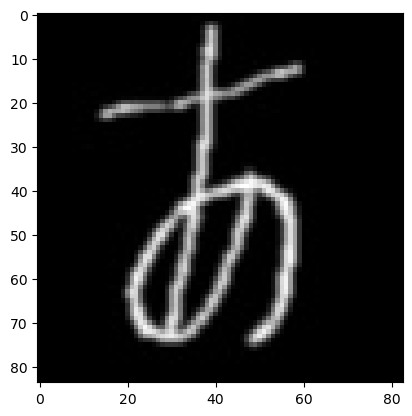

In [4]:
%matplotlib inline

# Example of intial dataset image
initial_image =  mpimg.imread(os.path.join(train_data_dir, 'A/kanaA0.jpg'))
plt.imshow(initial_image, cmap = plt.cm.gray)
plt.show()

In [5]:
def augment_image(image):
    # Data augmentation parameters
    angle = np.random.uniform(-10, 10)
    trans = {'x' : int(np.random.uniform(-10, 10)),  'y' : int(np.random.uniform(-4, 4))}
   
    # Augmentation pipeline
    aug = A.Compose([
        # 1 pixel padding to obtain 84x84 resolution
        A.PadIfNeeded(min_height=84, min_width=84, border_mode=0, value=0, always_apply=True), 
        A.Affine(translate_px=trans,rotate=angle, p=0.6),
        A.GaussianBlur(blur_limit = [3, 11], sigma_limit = 0, p=0.5),
        A.Downscale(scale_min=0.6, scale_max=0.8,interpolation={'downscale':cv2.INTER_CUBIC, 'upscale':cv2.INTER_CUBIC}, p=0.2),
        A.CoarseDropout(max_holes=8,
                        max_height=8,
                        max_width=8, 
                        min_holes=2,
                        min_height=3,
                        min_width=3,
                        p=0.2),
        A.OpticalDistortion(distort_limit=0.05,
                            shift_limit=0.05,
                            interpolation=1,
                            border_mode=4,
                            p=0.4)
    ])
    
    # Apply the augmentations
    augmented_image = aug(image=image)['image']
   
    
    return augmented_image

def perform_augmentation(dir,subdir_train, subdir_test, file, n_train, n_test):
    # Load the image
    image = cv2.imread(os.path.join(subdir_train, file))
    for i in range(0, n_train-1):
        # Perform data augmentation
        augmented_image = augment_image(image)

        # Save augmented image with a different name
        new_file_name = file.split(".")[0] + "_aug" + str(i+1) + ".jpg"
        cv2.imwrite(os.path.join(subdir_train, new_file_name), augmented_image)
     
    for i in range(0,n_test):
        # Perform data augmentation
        augmented_image = augment_image(image)

        # Save augmented image with a different name
        new_file_name = file.split(".")[0] + "_aug_test" + str(i+1) + ".jpg"
        cv2.imwrite(os.path.join(subdir_test, new_file_name), augmented_image)

# Iterate through all subdirectories and image files
for subdir, dirs, files in os.walk(train_data_dir):
    subdir_test = os.path.join(test_data_dir, os.path.basename(subdir))
    for file in files:
        file_path = os.path.join(subdir, file)
        image = cv2.imread(file_path)
        
        # Add padding and perform augmentation
        perform_augmentation(dirs,subdir,subdir_test, file, 8, 2) # 8000 images in the the train folder,2000 in the test folder

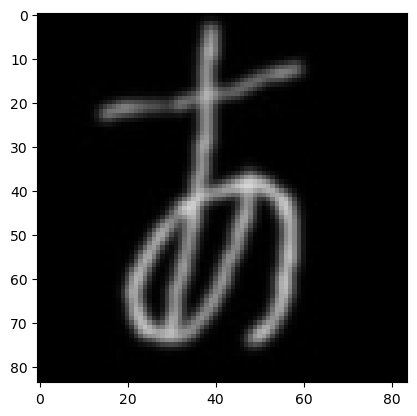

In [6]:
# Example of augmented image 
aug_image =  mpimg.imread(os.path.join(train_data_dir, 'A/kanaA0_aug4.jpg'))
plt.imshow(aug_image, cmap = plt.cm.binary)
plt.show()